# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview/evaluation


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV


In [6]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
df = train._append(test,ignore_index=False).reset_index()

df = df.drop("index", axis=1)


In [7]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)


Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


In [9]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)



          MSZoning      Ratio
MSZoning                     
RL            2265  77.595067
RM             460  15.758822
FV             139   4.761905
RH              26   0.890716
C (all)         25   0.856458
        Street    Ratio
Street                 
Pave      2907  99.5889
Grvl        12   0.4111
       Alley     Ratio
Alley                 
Grvl     120  4.110997
Pave      78  2.672148
          LotShape      Ratio
LotShape                     
Reg           1859  63.686194
IR1            968  33.162042
IR2             76   2.603631
IR3             16   0.548133
             LandContour      Ratio
LandContour                        
Lvl                 2622  89.825283
HLS                  120   4.110997
Bnk                  117   4.008222
Low                   60   2.055498
           Utilities      Ratio
Utilities                      
AllPub          2916  99.897225
NoSeWa             1   0.034258
           LotConfig      Ratio
LotConfig                      
Inside        

count    2919.000000
mean     1460.000000
std       842.787043
min         1.000000
5%        146.900000
10%       292.800000
20%       584.600000
30%       876.400000
40%      1168.200000
50%      1460.000000
60%      1751.800000
70%      2043.600000
80%      2335.400000
90%      2627.200000
95%      2773.100000
99%      2889.820000
max      2919.000000
Name: Id, dtype: float64


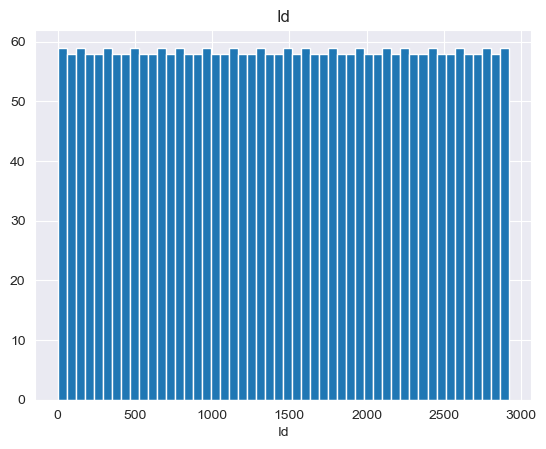

#####################################
count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
10%        20.000000
20%        20.000000
30%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
70%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64


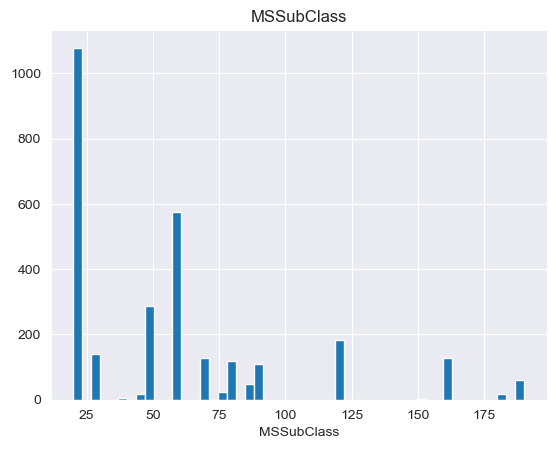

#####################################
count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
10%        43.000000
20%        53.000000
30%        60.000000
40%        63.000000
50%        68.000000
60%        73.000000
70%        78.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


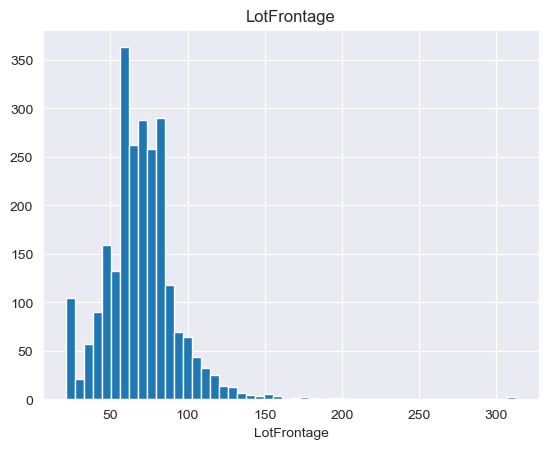

#####################################
count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
10%        4922.400000
20%        7007.600000
30%        7960.400000
40%        8741.000000
50%        9453.000000
60%       10151.600000
70%       11001.200000
80%       12203.800000
90%       14300.600000
95%       17142.900000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


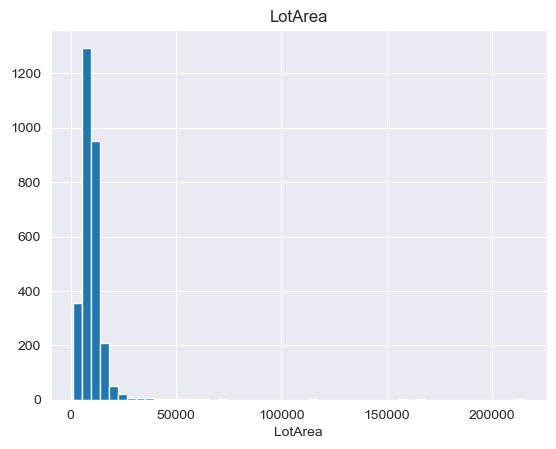

#####################################
count    2919.000000
mean        6.089072
std         1.409947
min         1.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         6.000000
70%         7.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%        10.000000
max        10.000000
Name: OverallQual, dtype: float64


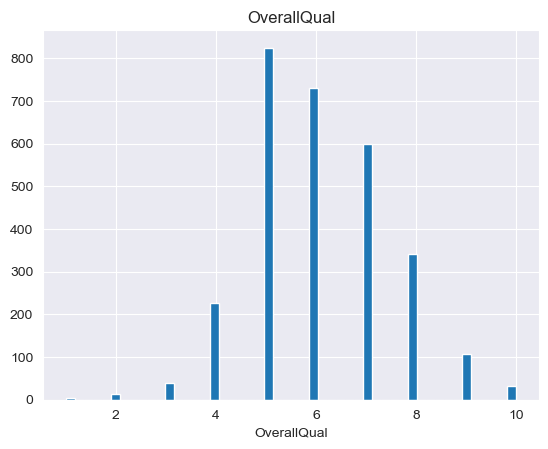

#####################################
count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
10%      1924.000000
20%      1947.000000
30%      1957.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
70%      1998.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


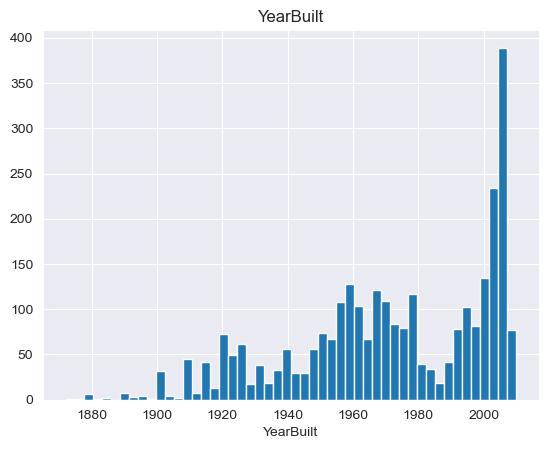

#####################################
count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
10%      1950.000000
20%      1960.000000
30%      1970.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
70%      2002.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


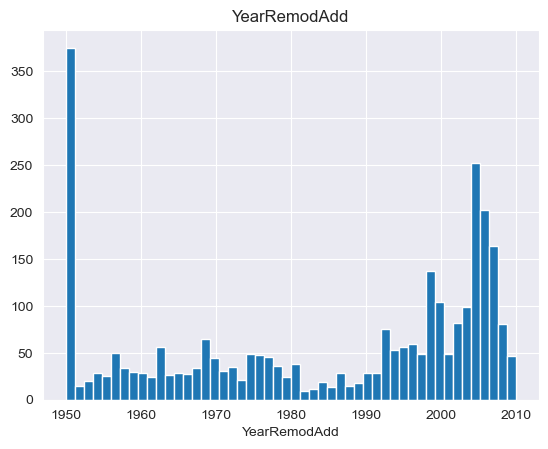

#####################################
count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%       120.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


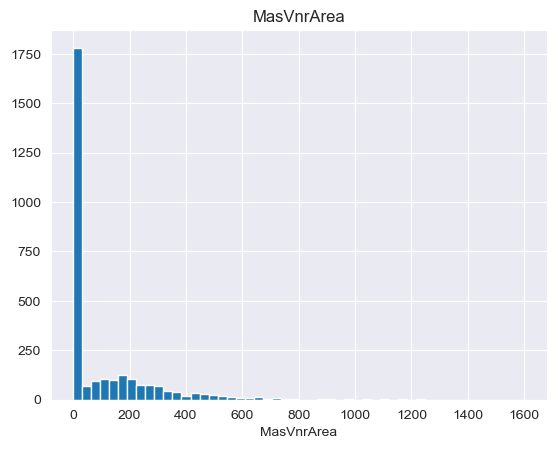

#####################################
count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
70%       656.000000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


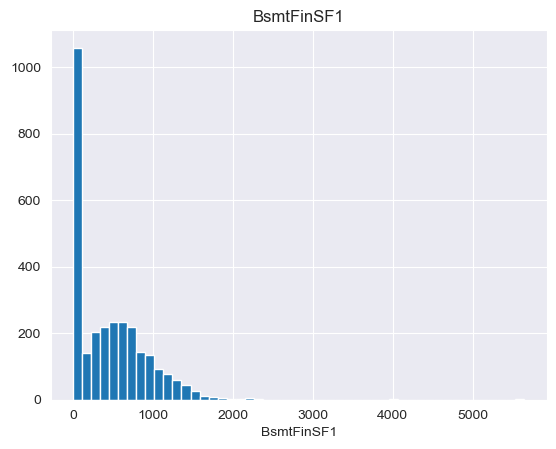

#####################################
count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       125.600000
95%       435.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


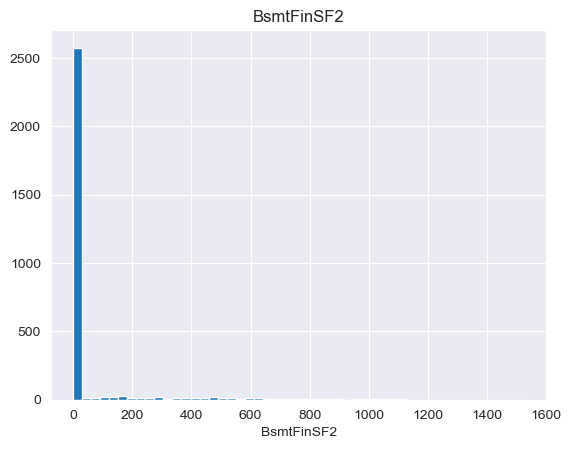

#####################################
count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
10%        56.000000
20%       174.000000
30%       270.000000
40%       365.800000
50%       467.000000
60%       595.000000
70%       732.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


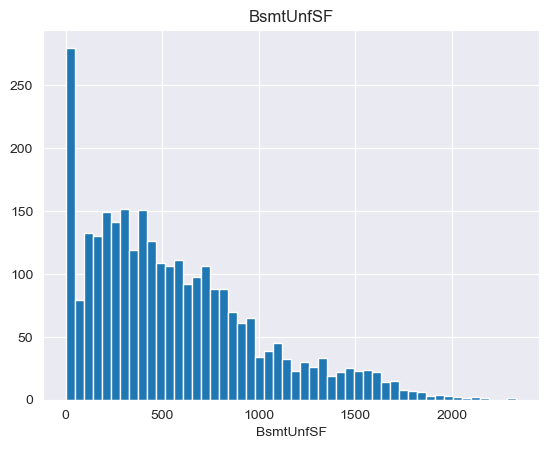

#####################################
count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
10%       600.000000
20%       741.000000
30%       836.000000
40%       911.000000
50%       989.500000
60%      1089.200000
70%      1216.000000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


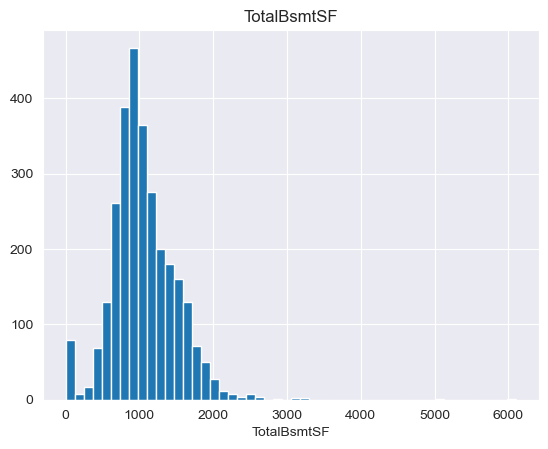

#####################################
count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
10%       744.800000
20%       847.000000
30%       914.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
70%      1314.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


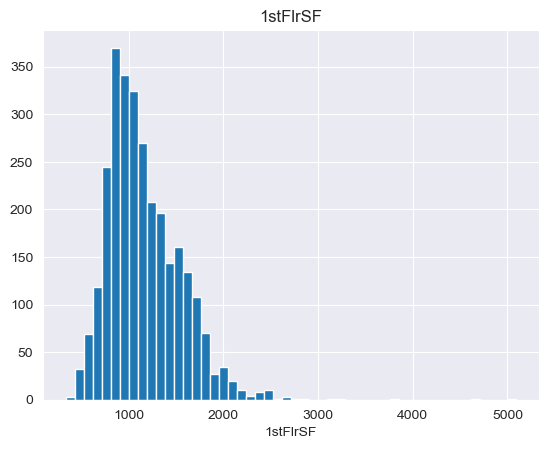

#####################################
count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
70%       636.000000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


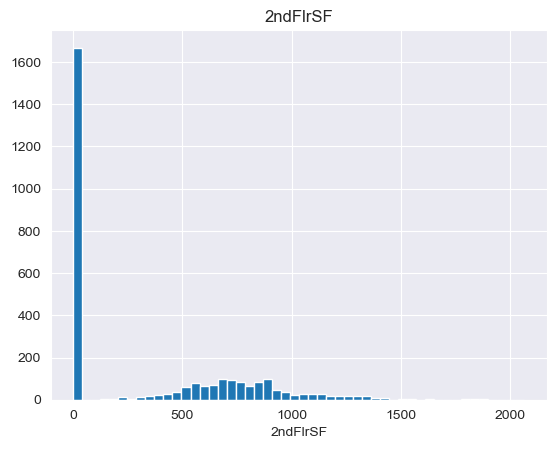

#####################################
count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


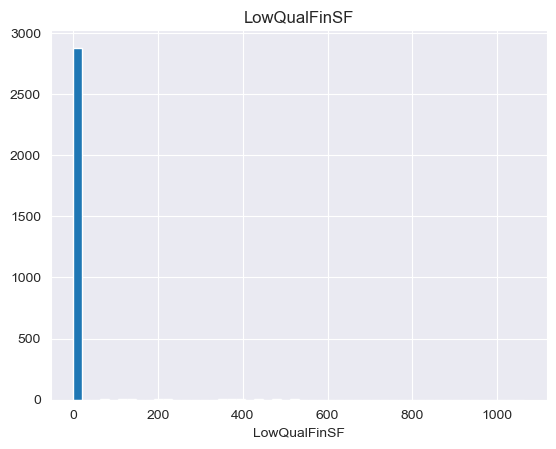

#####################################
count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
10%       923.800000
20%      1064.600000
30%      1200.000000
40%      1329.200000
50%      1444.000000
60%      1560.000000
70%      1680.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


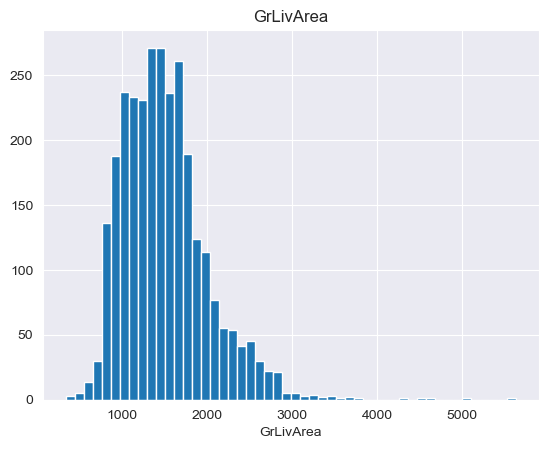

#####################################
count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
5%          4.000000
10%         5.000000
20%         5.000000
30%         6.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


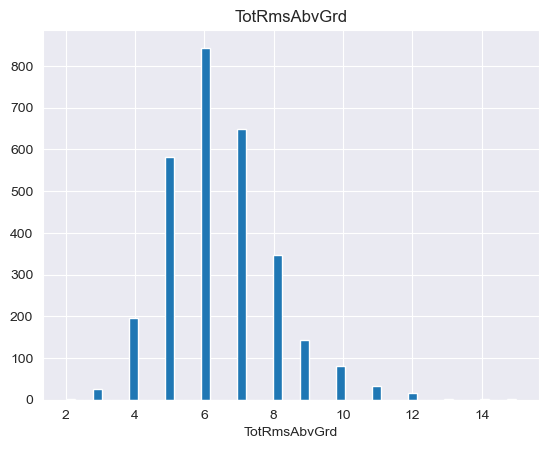

#####################################
count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
10%      1941.000000
20%      1957.000000
30%      1964.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
70%      1999.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


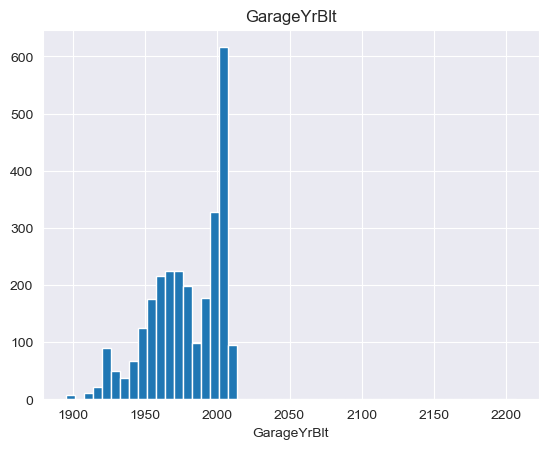

#####################################
count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
10%       240.000000
20%       296.000000
30%       379.000000
40%       440.000000
50%       480.000000
60%       513.000000
70%       560.900000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


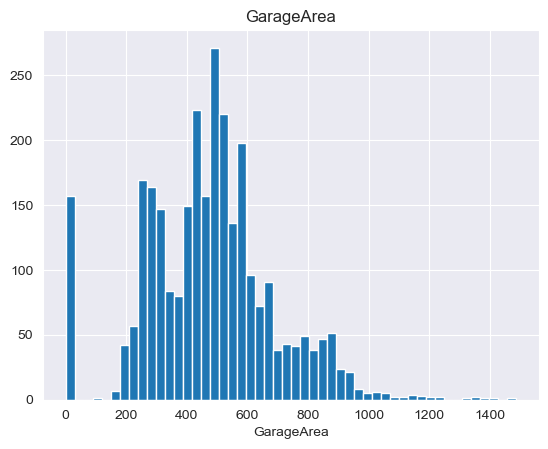

#####################################
count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
70%       144.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


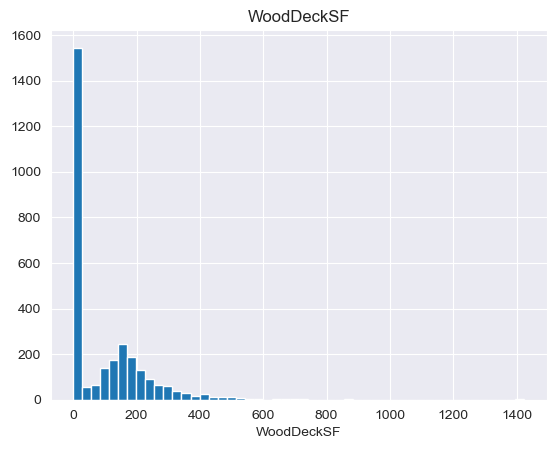

#####################################
count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
70%        58.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


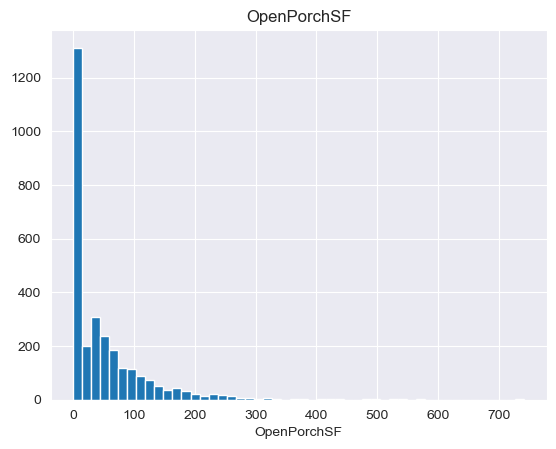

#####################################
count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


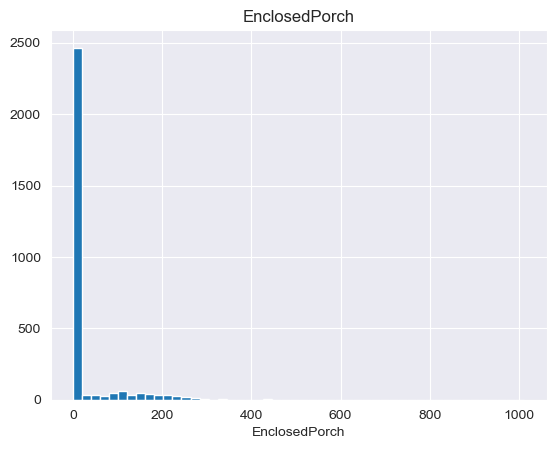

#####################################
count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


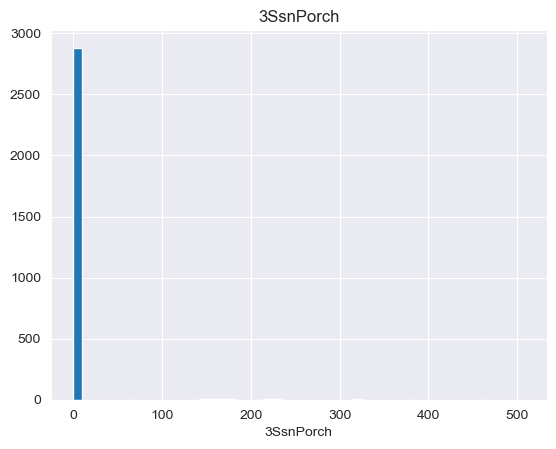

#####################################
count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%       161.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


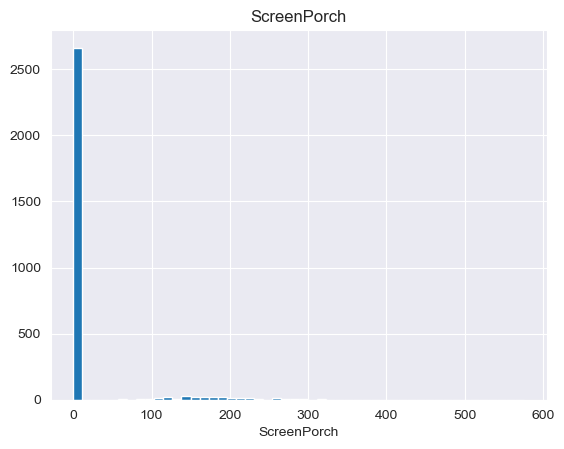

#####################################
count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
5%          0.000000
10%         0.000000
20%         0.000000
30%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
70%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%         0.000000
max       800.000000
Name: PoolArea, dtype: float64


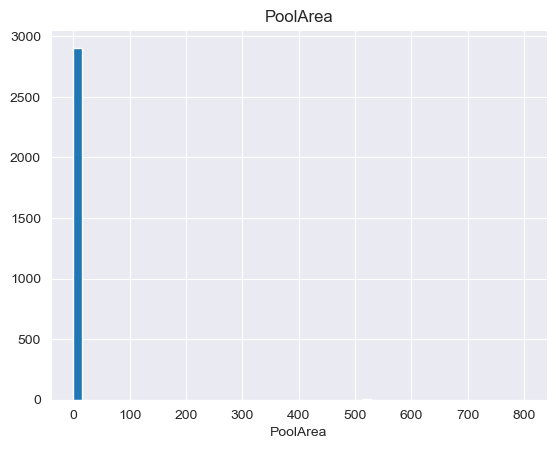

#####################################
count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


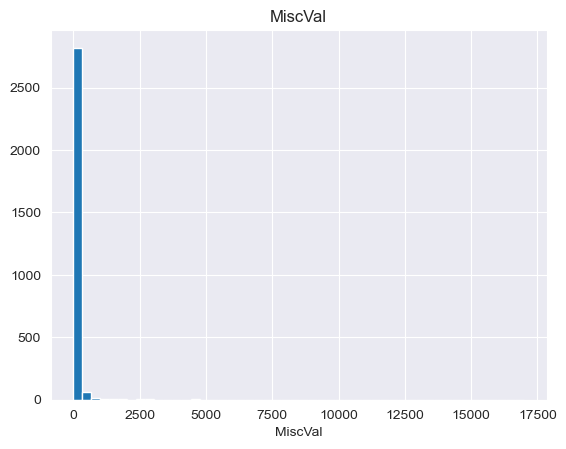

#####################################
count    2919.000000
mean        6.213087
std         2.714762
min         1.000000
5%          2.000000
10%         3.000000
20%         4.000000
30%         5.000000
40%         6.000000
50%         6.000000
60%         7.000000
70%         7.000000
80%         8.000000
90%        10.000000
95%        11.000000
99%        12.000000
max        12.000000
Name: MoSold, dtype: float64


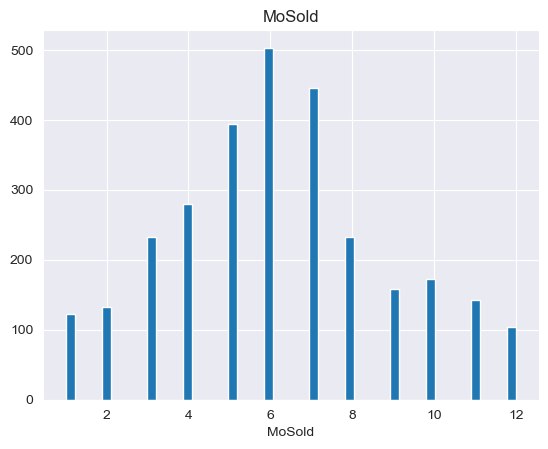

#####################################
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
10%      106475.000000
20%      124000.000000
30%      135500.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
70%      198620.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


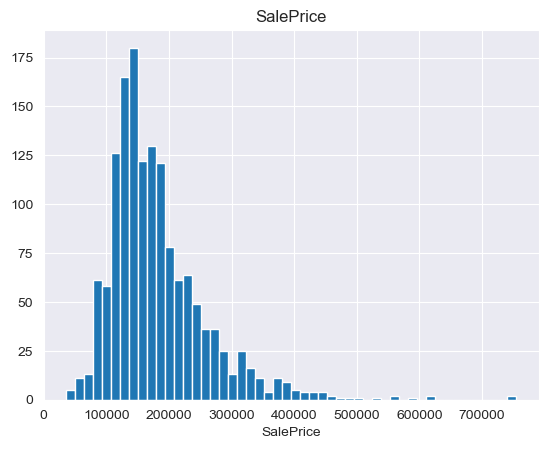

#####################################


In [10]:

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df, col, True)

            TARGET_MEAN
MSZoning               
C (all)    74528.000000
FV        214014.061538
RH        131558.375000
RL        191004.994787
RM        126316.830275


          TARGET_MEAN
Street               
Grvl    130190.500000
Pave    181130.538514


         TARGET_MEAN
Alley               
Grvl   122219.080000
Pave   168000.585366


            TARGET_MEAN
LotShape               
IR1       206101.665289
IR2       239833.365854
IR3       216036.500000
Reg       164754.818378


               TARGET_MEAN
LandContour               
Bnk          143104.079365
HLS          231533.940000
Low          203661.111111
Lvl          180183.746758


            TARGET_MEAN
Utilities              
AllPub     180950.95682
NoSeWa     137500.00000


             TARGET_MEAN
LotConfig               
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside     176938.047529


             TARGET_MEAN
LandSlope               
Gtl        179956.7

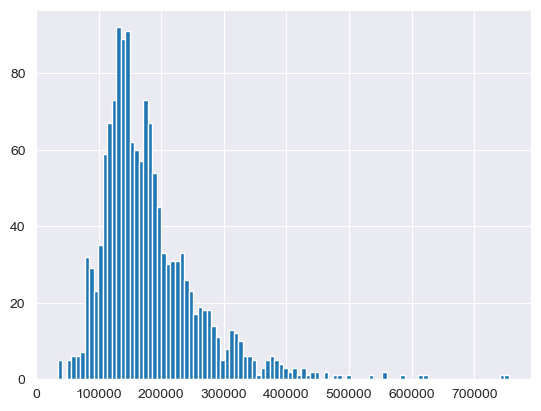

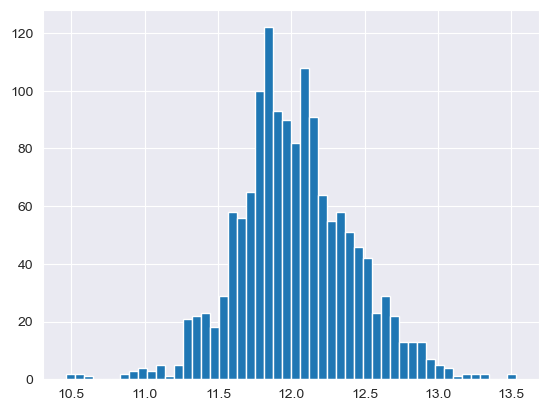

In [11]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)


# Bağımlı değişkenin incelenmesi
df["SalePrice"].hist(bins=100)
plt.show()

# Bağımlı değişkenin logaritmasının incelenmesi
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()


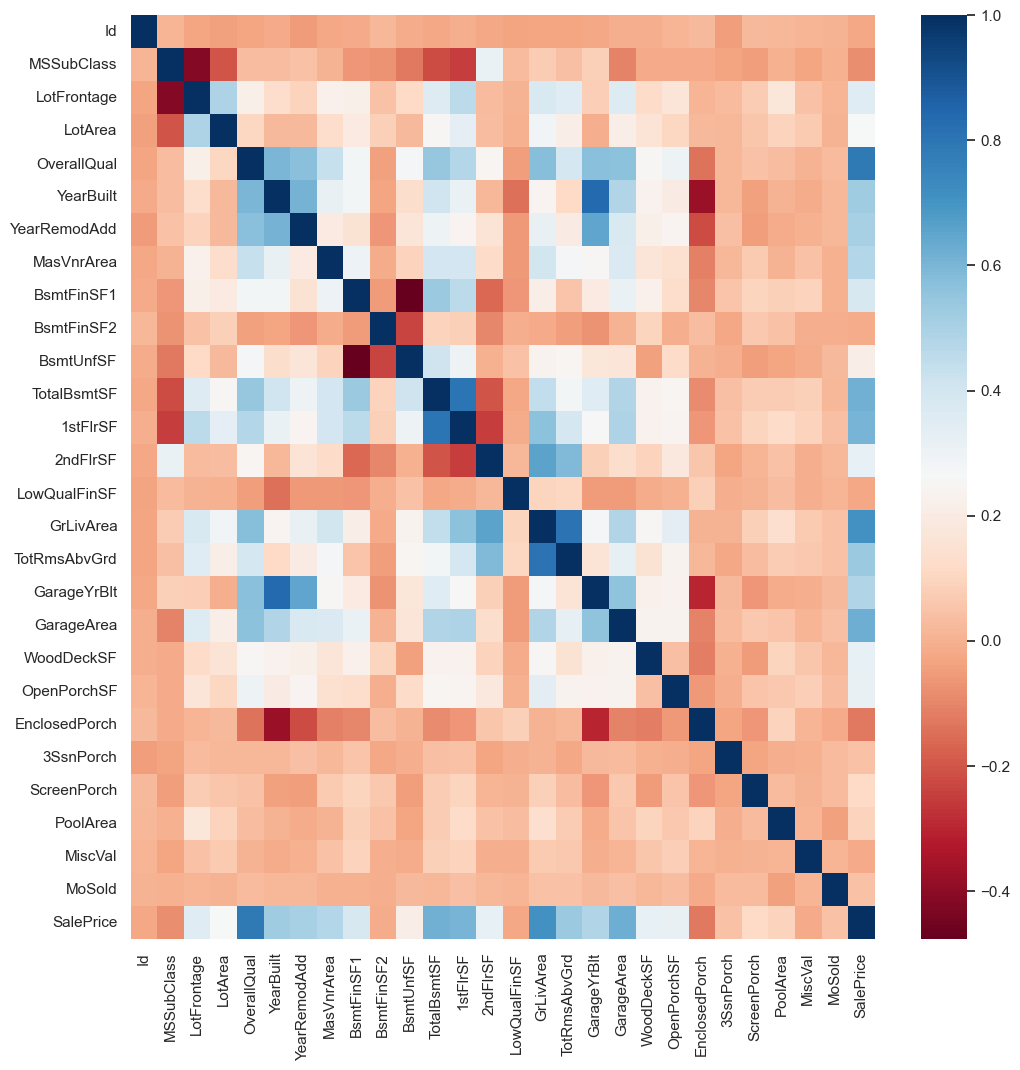

In [12]:

corr = df[num_cols].corr()
corr

# Korelasyonların gösterilmesi
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show()



def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list


feature engineering

In [15]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


In [16]:
# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))

Id False
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


In [17]:
# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)


C:\Users\reyiz\AppData\Local\Temp\ipykernel_16400\1503990467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3208.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\reyiz\AppData\Local\Temp\ipykernel_16400\1503990467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-9144.900000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\reyiz\AppData\Local\Temp\ipykernel_16400\1503990467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast 

In [18]:

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)


              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
MasVnrType      1766  60.50
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [19]:
df["Alley"].value_counts()
df["BsmtQual"].value_counts()


# Bazı değişkenlerdeki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

# Kolonlardaki boşlukların "No" ifadesi ile doldurulması
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


df = quick_missing_imp(df, num_method="median", cat_length=17)



              n_miss  ratio
MasVnrType      1766  60.50
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
Exterior2nd        1   0.03
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior1st        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03
# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars        

C:\Users\reyiz\AppData\Local\Temp\ipykernel_16400\1082942297.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("No",inplace=True)


In [20]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
          COUNT     RATIO    TARGET_MEAN
MSZoning                                
C (all)      25  0.008565   74528.000000
FV          139  0.047619  214014.061538
RH           26  0.008907  131558.375000
RL         2269  0.777321  191004.994787
RM          460  0.157588  126316.830275


Street : 2
        COUNT     RATIO    TARGET_MEAN
Street                                
Grvl       12  0.004111  130190.500000
Pave     2907  0.995889  181130.538514


Alley : 3
       COUNT     RATIO    TARGET_MEAN
Alley                                
Grvl     120  0.041110  122219.080000
No      2721  0.932169  183452.131483
Pave      78  0.026721  168000.585366


LotShape : 4
          COUNT     RATIO    TARGET_MEAN
LotShape                                
IR1         968  0.331620  206101.665289
IR2          76  0.026036  239833.365854
IR3          16  0.005481  216036.500000
Reg        1859  0.636862  164754.818378


LandContour : 4
             COUNT     RATIO    TARGET_MEAN
LandCo

In [21]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df


rare_encoder(df,0.01)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.0,60,RL,65.0,8450.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,2.0,2008,WD,Normal,208500.0
1,2.0,20,RL,80.0,9600.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,5.0,2007,WD,Normal,181500.0
2,3.0,60,RL,68.0,11250.0,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,9.0,2008,WD,Normal,223500.0
3,4.0,70,RL,60.0,9550.0,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,2.0,2006,WD,Abnorml,140000.0
4,5.0,60,RL,84.0,14260.0,Pave,No,IR1,Lvl,AllPub,...,0,No,No,No,0,12.0,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915.0,160,RM,21.0,1936.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,6.0,2006,WD,Normal,NaN
2915,2916.0,160,RM,21.0,1894.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,4.0,2006,WD,Abnorml,NaN
2916,2917.0,20,RL,160.0,20000.0,Pave,No,Reg,Lvl,AllPub,...,0,No,No,No,0,9.0,2006,WD,Abnorml,NaN
2917,2918.0,85,RL,62.0,10441.0,Pave,No,Reg,Lvl,AllPub,...,0,No,MnPrv,Shed,0,7.0,2006,WD,Normal,NaN


In [22]:


df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]

df["NEW_Garage*GrLiv"] = (df["GarageArea"] * df["GrLivArea"])

df["TotalQual"] = df[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence"]].sum() # 42


# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] # 32

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 # 56

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF # 93

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35


# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73


df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48



drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

In [23]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2919
Variables: 92
cat_cols: 50
num_cols: 42
cat_but_car: 0
num_but_cat: 15


In [24]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
    label_encoder(df, col)

In [25]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [26]:

#  Train ve Test verisini ayırınız. (SalePrice değişkeni boş olan değerler test verisidir.)
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

y = train_df['SalePrice'] # np.log1p(df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

# Train verisi ile model kurup, model başarısını değerlendiriniz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)


In [27]:
models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]


In [28]:
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 42645.1758 (LR) 
RMSE: 47557.3947 (KNN) 
RMSE: 39240.3981 (CART) 
RMSE: 29459.0313 (RF) 
RMSE: 25720.3474 (GBM) 
RMSE: 27577.7231 (XGBoost) 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6460
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 176
[LightGBM] [Info] Start training from score 180717.091610
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6462
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 171
[LightGBM] [Info] Start training from score 180407.575342

In [29]:
df['SalePrice'].mean()
df['SalePrice'].std()

79442.50288288663

In [30]:

train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)


In [31]:
# Verinin eğitim ve tet verisi olarak bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)


In [32]:

lgbm = LGBMRegressor().fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

y_pred
# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y = np.expm1(y_pred)
new_y
new_y_test = np.expm1(y_test)
new_y_test

np.sqrt(mean_squared_error(new_y_test, new_y))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6459
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 170
[LightGBM] [Info] Start training from score 12.027102


23732.871096691535

In [33]:

lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))


lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]
               #"colsample_bytree": [0.5, 0.7, 1]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)



final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6460
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 176
[LightGBM] [Info] Start training from score 12.021409
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6462
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 171
[LightGBM] [Info] Start training from score 12.023288
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6793
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 180
[LightGBM] [Info] Start training from score 12.024057


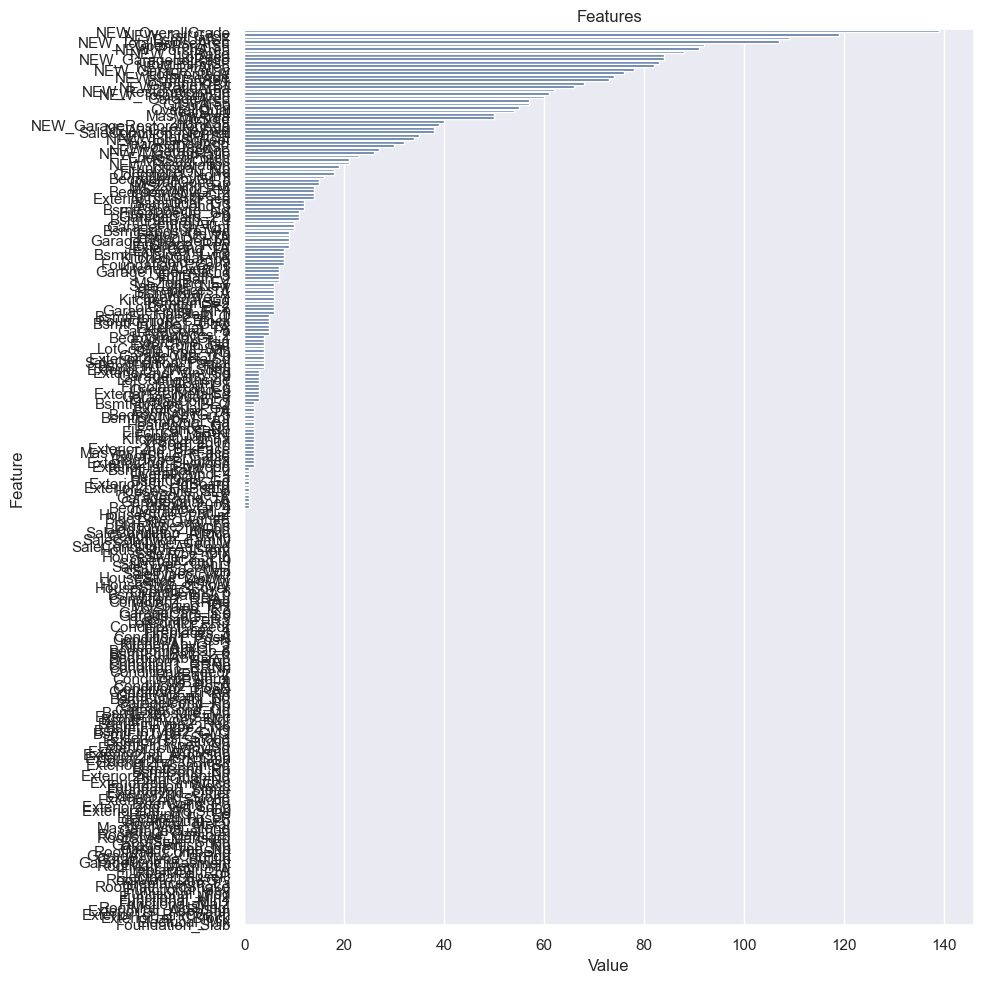

In [34]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMRegressor()
model.fit(X, y)

plot_importance(model, X)


In [35]:

model = LGBMRegressor()
model.fit(X, y)
predictions = model.predict(test_df.drop(["Id","SalePrice"], axis=1))

dictionary = {"Id":test_df.index, "SalePrice":predictions}
dfSubmission = pd.DataFrame(dictionary)
dfSubmission.to_csv("housePricePredictions.csv", index=False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6793
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 180
[LightGBM] [Info] Start training from score 12.024057
